In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pythia as pt
from tqdm import tqdm as nice_bar
import seaborn as sns

In [2]:
np.random.seed(6)

sns.set_style()
filename = 'data/uniform_1/npz/Digital_PPG.npz'
age = '25'

data = np.load(filename, allow_pickle=True)["data"].item()
x_labels = data['parameters']
data = data[age]
xs = data[0]
print(xs.shape)
#normalize x
xs = (xs-xs.min(axis=0))/(xs.max(axis=0)-xs.min(axis=0))
#xs=torch.from_numpy(xs).float()
ys = data[1]
print(ys.shape)

x_train, x_test, y_train, y_test = train_test_split(xs,ys, train_size=.8)

(3429, 6)
(3429, 469)


In [43]:
print(x_labels)

['hr', 'sv', 'lvet', 'dia', 'pwv', 'mbp']


## Run a linear lasso regression

In [3]:
#run a linear lasso regression
model = Lasso()
model.fit(x_train,y_train)
print(np.sum(model.coef_!=0))
print(model.intercept_.shape)

/home/matthias/environments/master/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


0
(469,)


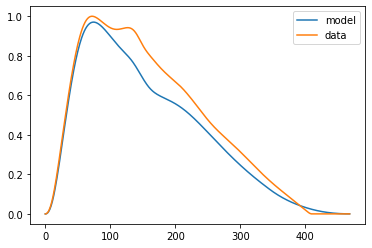

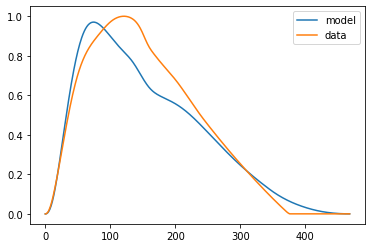

In [4]:
y_pred = model.predict(x_test)
plt.plot(y_pred[0].reshape(-1), label = 'model')
plt.plot(y_test[0], label = 'data')
plt.legend()
plt.figure()
plt.plot(y_pred[1].reshape(-1), label = 'model')
plt.plot(y_test[1], label = 'data')
plt.legend()

Mean squared error =  0.009246126739017407


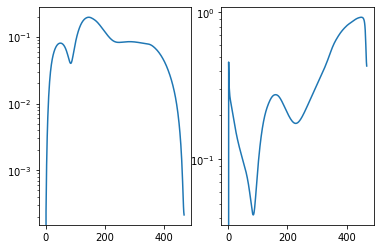

In [5]:
#compute error
err_L2 = np.sqrt(np.sum((y_pred - y_test)**2, axis=0) / y_test.shape[0])
denominator = np.sqrt(np.sum(y_test**2, axis=0) / y_test.shape[0]) + 1e-4
err_L2_rel = err_L2 / denominator
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error = ', mse)
fig, ax = plt.subplot_mosaic([["abs", "rel"]])
ax["abs"].semilogy(err_L2)
ax["rel"].semilogy(err_L2_rel)
plt.show()

## Run a Polynomial Lasso regression

In [6]:
#run a polynomial regression with the l1 loss from x on y to see if there are any variables less important
features = PolynomialFeatures(degree=3)
X = features.fit_transform(xs)
X_train,X_test, Y_train,Y_test = train_test_split(X,ys, train_size=.8)
print(X.shape)
print(ys.shape)

(3429, 84)
(3429, 469)


In [7]:
model = Lasso(alpha = .05)
model.fit(X_train,y_train)

/home/matthias/environments/master/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.05)

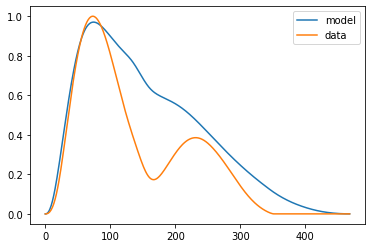

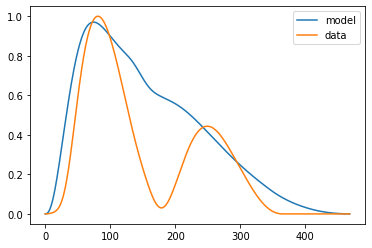

In [8]:
#print(x_test.shape)
y_pred = model.predict(X_test)
plt.plot(y_pred[0].reshape(-1), label = 'model')
plt.plot(Y_test[0], label = 'data')
plt.legend()
plt.figure()
plt.plot(y_pred[1].reshape(-1), label = 'model')
plt.plot(Y_test[1], label = 'data')
plt.legend()

Mean squared error =  0.00977878776636795


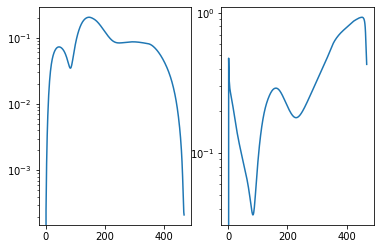

In [9]:
#compute error
err_L2 = np.sqrt(np.sum((y_pred - Y_test)**2, axis=0) / Y_test.shape[0])
denominator = np.sqrt(np.sum(Y_test**2, axis=0) / Y_test.shape[0]) + 1e-4
err_L2_rel = err_L2 / denominator
mse = mean_squared_error(Y_test, y_pred)
print('Mean squared error = ', mse)
fig, ax = plt.subplot_mosaic([["abs", "rel"]])
ax["abs"].semilogy(err_L2)
ax["rel"].semilogy(err_L2_rel)
plt.show()

In [10]:
print(np.sum(model.coef_!=0))
print(model.intercept_.shape)
print(model.coef_.shape)

0
(469,)
(469, 84)


## Run a Ridge Regression

In [11]:
model = Ridge()
model.fit(X_train, Y_train)

Ridge()

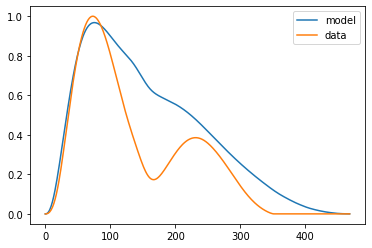

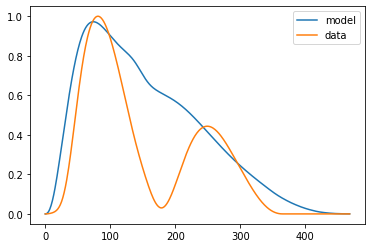

In [12]:
y_pred = model.predict(X_test)
plt.plot(y_pred[0].reshape(-1), label = 'model')
plt.plot(Y_test[0], label = 'data')
plt.legend()
plt.figure()
plt.plot(y_pred[1].reshape(-1), label = 'model')
plt.plot(Y_test[1], label = 'data')
plt.legend()

Mean squared error =  0.009964780902844009


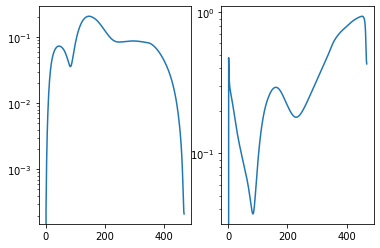

In [13]:
#compute error
err_L2 = np.sqrt(np.sum((y_pred - Y_test)**2, axis=0) / Y_test.shape[0])
denominator = np.sqrt(np.sum(Y_test**2, axis=0) / Y_test.shape[0]) + 1e-4
err_L2_rel = err_L2 / denominator
mse = mean_squared_error(Y_test, y_pred)
print('Mean squared error = ', mse)
fig, ax = plt.subplot_mosaic([["abs", "rel"]])
ax["abs"].semilogy(err_L2)
ax["rel"].semilogy(err_L2_rel)
plt.show()

In [14]:
print(np.sum(model.coef_!=0))
print(model.intercept_.shape)
print(model.coef_.shape)

38844
(469,)
(469, 84)


## Run a polynomial chaos expansion

In [15]:
# load parameter domain
csv_path = '../m4aim_hd/lit/'
means = pd.read_csv(csv_path+"mean.csv")
stds = pd.read_csv(csv_path+"std.csv")
means = means.drop(columns = ['age'])
stds = stds.drop(columns = ['age'])
print(means.head())
print(stds.head())
domain = np.array([np.min(means-1*stds, axis=0),
                   np.max(means+1*stds, axis=0)]).T

print(domain)
# define parameters
params = [pt.parameter.RandomParameter(name, dom, "uniform")
          for name, dom in zip(x_labels, domain)]
# define multiindices for sparse PC
deg = 6
mdx = pt.index.PCMultiIndex(len(params))
mdx.mdx = mdx.mdxFromShape([deg]*len(params))
mdx.mdxLimitAbs(deg)
mdx.refresh()

     hr    sv  lvet   dia  pwv   mbp
0  73.0  66.8   283  36.7  5.9  89.2
1  76.3  64.1   284  37.8  6.4  92.8
2  77.0  61.3   283  39.0  7.3  96.3
3  77.0  58.7   282  40.2  8.0  96.2
4  76.3  55.8   282  41.4  8.9  95.4
    hr    sv  lvet  dia  pwv  mbp
0  9.1  13.1    23  2.6  0.6  6.2
1  9.1  12.5    23  2.7  0.8  6.1
2  9.0  11.6    23  2.8  0.9  6.1
3  9.1  11.1    23  2.9  1.1  6.0
4  9.0  10.4    23  3.0  1.3  5.9
[[ 63.9  86.1]
 [ 43.8  79.9]
 [259.  307. ]
 [ 34.1  45.6]
 [  5.3  11.3]
 [ 83.  102.4]]


In [16]:
# run PC approximation
w_train = np.ones(x_train.shape[0]) / x_train.shape[0]
model = pt.chaos.PolynomialChaos(params, mdx, x_train, w_train, y_train)

(686, 469)
Mean squared error =  0.0273364294576493


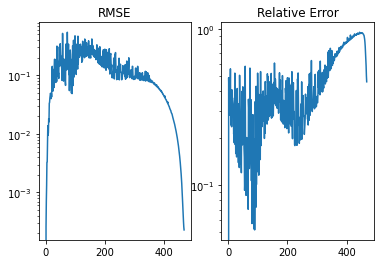

In [17]:
# compute error
y_approx = model.approximation(x_test)
err_L2 = np.sqrt(np.sum((y_approx - y_test)**2, axis=0) / y_test.shape[0])
denominator = np.sqrt(np.sum(y_test**2, axis=0) / y_test.shape[0]) + 1e-4
err_L2_rel = err_L2 / denominator
mse = mean_squared_error(y_test, y_approx)
print(y_approx.shape)
print('Mean squared error = ', mse)
fig, ax = plt.subplot_mosaic([["abs", "rel"]])
ax["abs"].semilogy(err_L2)
ax['abs'].set_title('RMSE')
ax["rel"].semilogy(err_L2_rel)
ax['rel'].set_title('Relative Error')
plt.show()

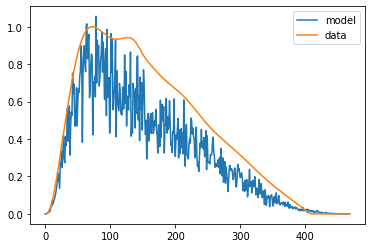

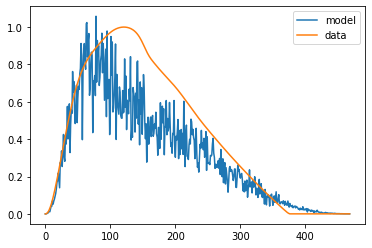

In [18]:
plt.plot(y_approx[0],label = 'model')
plt.plot(y_test[0], label = 'data')
plt.legend()
plt.figure()
plt.plot(y_approx[1],label = 'model')
plt.plot(y_test[1], label = 'data')
plt.legend()
plt.show()

In [19]:
np.linalg.norm(y_approx[0]-y_approx[1])

0.19759761038803297

## Train an MLP

In [20]:
from torch import nn
import torch
from torch.optim import Adam
import tqdm


In [21]:
DIMENSION = xs.shape[1]
COND_DIM = ys.shape[1]
MLP = nn.Sequential(nn.Linear(DIMENSION, 256),
                      nn.ReLU(),
                      nn.Linear(256, 256),
                      nn.ReLU(),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                    nn.Linear(256, 256),
                    nn.ReLU(),
                      nn.Linear(256, COND_DIM))
optimizer_mlp = Adam(MLP.parameters(),lr = 1e-4)
num_epochs = 200

In [22]:
def train_MLP_epoch(optimizer, model, epoch_data_loader):
    mean_loss = 0
    mse = nn.MSELoss()
    for k, (x, y) in enumerate(epoch_data_loader()):
        cur_batch_size = len(x)
        y_pred = model(x)
        loss = mse(y,y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss = mean_loss * k / (k + 1) + loss.data.item() / (k + 1)
        
    return mean_loss

def train_LSTM_epoch(optimizer, model, epoch_data_loader):
    mean_loss = 0
    mse = nn.MSELoss()
    for k, (x, y) in enumerate(epoch_data_loader()):
        cur_batch_size = len(x)
        y_pred,hidden = model(x)
        loss = mse(y,y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss = mean_loss * k / (k + 1) + loss.data.item() / (k + 1)
        
    return mean_loss

def get_epoch_dataloader(x_train, y_train):
    perm = torch.randperm(len(x_train))
    x = x_train[perm]
    y = y_train[perm]
    #y = y + sigma*torch.randn_like(y)
    batch_size = 100
    def epoch_data_loader():
        for i in range(0, len(x), batch_size):
            yield x[i:i + batch_size], y[i:i + batch_size]

    return epoch_data_loader



In [23]:
#convert data to torch
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

--------------
Num Epochs =  0
Mean absolute approximation error of the forward problem: 0.409213
--------------
Num Epochs =  200


Text(0.5, 1.0, 'Mean absolute Error of the forward problem')

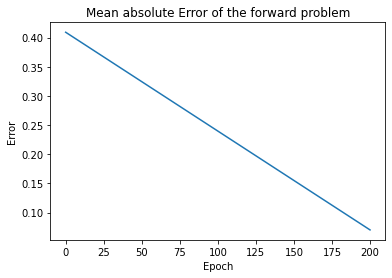

In [24]:
%matplotlib inline
MLP_error = []
epochs = []
test_loader = get_epoch_dataloader(x_test, y_test)
#train MLP surrogate
for i in range(num_epochs):
    data_loader = get_epoch_dataloader(x_train,y_train)

    #print the absolute error every 200 epochs
    if i%200 == 0:
        MLP.eval()
        err = []
        for k, (x, y) in enumerate(test_loader()):
            diff = torch.abs(y - MLP(x))
            err.append(diff.detach().data.numpy())

        err = np.concatenate(err, axis=0)
        print('--------------')
        print('Num Epochs = ', i)
        print('Mean absolute approximation error of the forward problem:', np.mean(err))
        MLP_error.append(np.mean(err))
        epochs.append(i)

    loss = train_MLP_epoch(optimizer_mlp, MLP, data_loader)
    #prog_bar.set_description('loss: {:.4f}'.format(loss))
    #prog_bar.update()

#last evaluation after training is done
MLP.eval()
err = []
for k, (x, y) in enumerate(test_loader()):
    diff = torch.abs(y - MLP(x))
    # print(diff.shape)
    err.append(diff.detach().data.numpy())

err = np.concatenate(err, axis=0)
print('--------------')
print('Num Epochs = ', num_epochs)
MLP_error.append(np.mean(err))
epochs.append(num_epochs)

#plot the mean absolute error against number of epochs
plt.plot(epochs, MLP_error)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Mean absolute Error of the forward problem')

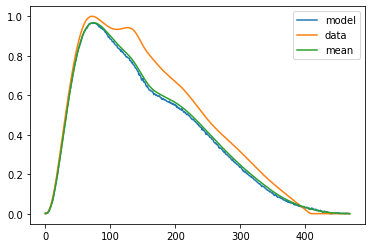

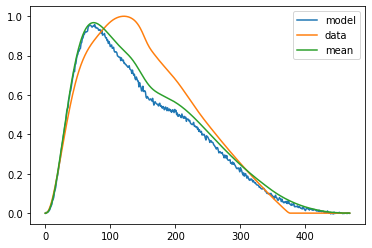

In [45]:
MLP.eval()
with torch.no_grad():
    y_pred = MLP(x_test)
    plt.plot(y_pred[0].reshape(-1), label = 'model')
    plt.plot(y_test[0], label = 'data')
    plt.plot(torch.mean(y_test, axis = 0), label = 'mean')
    plt.legend()
    plt.figure()
    plt.plot(y_pred[1].reshape(-1), label = 'model')
    plt.plot(y_test[1], label = 'data')
    plt.plot(torch.mean(y_test, axis = 0), label = 'mean')
    plt.legend()

Mean squared error =  0.010048471


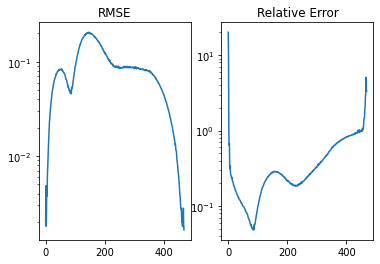

In [26]:
#compute error
with torch.no_grad():
    err_L2 = torch.sqrt(torch.sum((y_pred - y_test)**2, axis=0) / y_test.shape[0])
    denominator = torch.sqrt(torch.sum(y_test**2, axis=0) / y_test.shape[0]) + 1e-4
    err_L2_rel = err_L2 / denominator
    mse = mean_squared_error(y_test.detach().numpy(), y_pred.detach().numpy())
    print('Mean squared error = ', mse)
    fig, ax = plt.subplot_mosaic([["abs", "rel"]])
    ax["abs"].semilogy(err_L2)
    ax['abs'].set_title('RMSE')
    ax['rel'].set_title('Relative Error')
    ax["rel"].semilogy(err_L2_rel)
    plt.show()

## Train an LSTM model
First, we need to restructure the data to account for autoregression

In [46]:
def sequentialize(x,y):
    y_timeseries = y.reshape((-1,y.shape[1],1))
    x_timeseries = x.repeat(1,y.shape[1]).reshape((x.shape[0], y.shape[1], x.shape[1]))
    x_timeseries = torch.cat((x_timeseries,y_timeseries), dim = 2)
    x_timeseries = x_timeseries[:,:-1,:]
    y_timeseries = y_timeseries[:,1:,:]

    return x_timeseries, y_timeseries

x_train_series, y_train_series = sequentialize(x_train, y_train)
x_test_series, y_test_series = sequentialize(x_test, y_test)

In [47]:
print(x_train_series.shape)
print(y_train_series.shape)

torch.Size([2743, 468, 7])
torch.Size([2743, 468, 1])


In [28]:
LSTM = nn.LSTM(input_size = x_train_series.shape[-1], hidden_size = 1, num_layers = 1, batch_first = True)
optimizer_LSTM = Adam(LSTM.parameters(),lr = 1e-4)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

--------------
Num Epochs =  0
Test error: 0.28966656


loss: 0.0043: 100%|███████████████████████████| 200/200 [06:41<00:00,  2.01s/it]

--------------
Num Epochs =  200


Text(0.5, 1.0, 'Test Error')

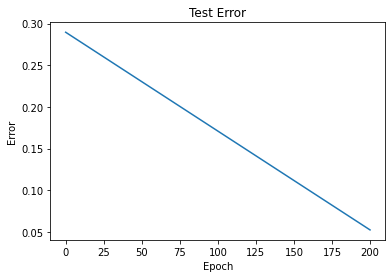

In [29]:
%matplotlib inline
LSTM_error = []
epochs = []
test_loader = get_epoch_dataloader(x_test_series, y_test_series)

prog_bar = nice_bar(total=num_epochs)
#train LSTM surrogate
for i in range(num_epochs):
    data_loader = get_epoch_dataloader(x_train_series,y_train_series)

    #print the absolute error every 200 epochs
    if i%200 == 0:
        LSTM.eval()
        err = []
        for k, (x, y) in enumerate(test_loader()):
            y_pred,hidden = LSTM(x)
            diff = torch.abs(y - y_pred)
            err.append(diff.detach().data.numpy())

        err = np.concatenate(err, axis=0)
        print('--------------')
        print('Num Epochs = ', i)
        print('Test error:', np.mean(err))
        LSTM_error.append(np.mean(err))
        epochs.append(i)

    loss = train_LSTM_epoch(optimizer_LSTM, LSTM, data_loader)
    prog_bar.set_description('loss: {:.4f}'.format(loss))
    prog_bar.update()

prog_bar.close()

#last evaluation after training is done
LSTM.eval()
err = []
for k, (x, y) in enumerate(test_loader()):
    y_pred,hidden = LSTM(x)
    diff = torch.abs(y - y_pred)
    # print(diff.shape)
    err.append(diff.detach().data.numpy())

err = np.concatenate(err, axis=0)
print('--------------')
print('Num Epochs = ', num_epochs)
LSTM_error.append(np.mean(err))
epochs.append(num_epochs)

#plot the mean absolute error against number of epochs
plt.plot(epochs, LSTM_error)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Test Error')

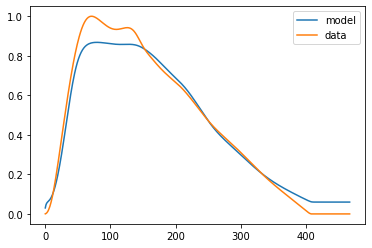

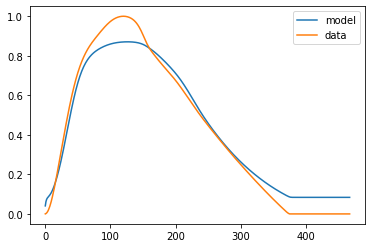

In [30]:
LSTM.eval()
with torch.no_grad():
    y_pred, hidden = LSTM(x_test_series)
    plt.plot(y_pred[0].reshape(-1), label = 'model')
    plt.plot(y_test_series[0], label = 'data')
    plt.legend()
    plt.figure()
    plt.plot(y_pred[1].reshape(-1), label = 'model')
    plt.plot(y_test_series[1], label = 'data')
    plt.legend()

Mean squared error =  0.0044749263


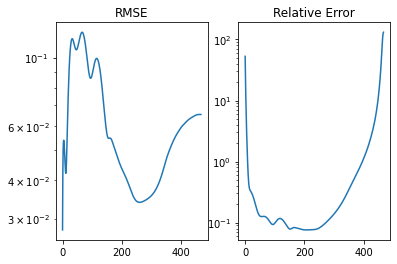

In [31]:
#compute error
with torch.no_grad():
    err_L2 = torch.sqrt(torch.sum((y_pred - y_test_series)**2, axis=0) / y_test_series.shape[0])
    denominator = torch.sqrt(torch.sum(y_test_series**2, axis=0) / y_test_series.shape[0]) + 1e-4
    err_L2_rel = err_L2 / denominator
    mse = mean_squared_error(y_test_series.detach().numpy().reshape((-1,y_test_series.shape[1])), y_pred.detach().numpy().reshape(-1,y_test_series.shape[1]))
    print('Mean squared error = ', mse)
    fig, ax = plt.subplot_mosaic([["abs", "rel"]])
    ax["abs"].semilogy(err_L2)
    ax['abs'].set_title('RMSE')
    ax['rel'].set_title('Relative Error')
    ax["rel"].semilogy(err_L2_rel)
    plt.show()

In [32]:
#build a fully auto-regressive model to compare
x_train_series = y_train.reshape((-1,y_train.shape[1], 1))[:,:-1,:]
y_train_series = y_train.reshape((-1,y_train.shape[1],1))[:,1:,:]

x_test_series = y_test.reshape((-1,y_test.shape[1], 1))[:,:-1,:]
y_test_series = y_test.reshape((-1,y_test.shape[1],1))[:,1:,:]

In [33]:
LSTM_auto = nn.LSTM(input_size = x_train_series.shape[-1], hidden_size = 1, num_layers = 1, batch_first = True)
optimizer_LSTM = Adam(LSTM_auto.parameters(),lr = 1e-4)

  0%|                                                   | 0/200 [00:00<?, ?it/s]

--------------
Num Epochs =  0
Test error: 0.31913206


loss: 0.0128: 100%|███████████████████████████| 200/200 [06:39<00:00,  2.00s/it]


--------------
Num Epochs =  200


Text(0.5, 1.0, 'Test Error')

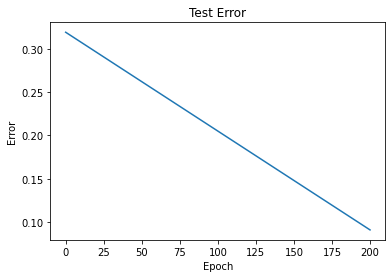

In [34]:
%matplotlib inline
LSTM_error = []
epochs = []
test_loader = get_epoch_dataloader(x_test_series, y_test_series)
prog_bar = nice_bar(total=num_epochs)
#train LSTM surrogate
for i in range(num_epochs):
    data_loader = get_epoch_dataloader(x_train_series,y_train_series)

    #print the absolute error every 200 epochs
    if i%200 == 0:
        LSTM_auto.eval()
        err = []
        for k, (x, y) in enumerate(test_loader()):
            y_pred_auto,hidden = LSTM_auto(x)
            diff = torch.abs(y - y_pred_auto)
            err.append(diff.detach().data.numpy())

        err = np.concatenate(err, axis=0)
        print('--------------')
        print('Num Epochs = ', i)
        print('Test error:', np.mean(err))
        LSTM_error.append(np.mean(err))
        epochs.append(i)

    loss = train_LSTM_epoch(optimizer_LSTM, LSTM_auto, data_loader)
    prog_bar.set_description('loss: {:.4f}'.format(loss))
    prog_bar.update()

prog_bar.close()

#last evaluation after training is done
LSTM_auto.eval()
err = []
for k, (x, y) in enumerate(test_loader()):
    y_pred_auto,hidden = LSTM_auto(x)
    diff = torch.abs(y - y_pred_auto)
    # print(diff.shape)
    err.append(diff.detach().data.numpy())

err = np.concatenate(err, axis=0)
print('--------------')
print('Num Epochs = ', num_epochs)
LSTM_error.append(np.mean(err))
epochs.append(num_epochs)

#plot the mean absolute error against number of epochs
plt.plot(epochs, LSTM_error)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Test Error')

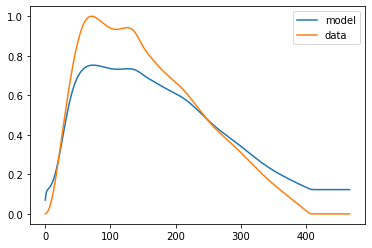

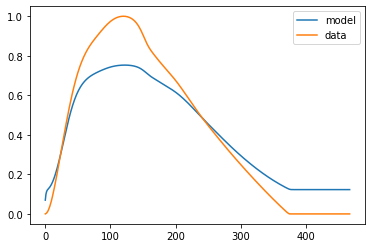

In [35]:
LSTM_auto.eval()
with torch.no_grad():
    y_pred_auto, hidden = LSTM_auto(x_test_series)
    plt.plot(y_pred_auto[0].reshape(-1), label = 'model')
    plt.plot(y_test_series[0], label = 'data')
    plt.legend()
    plt.figure()
    plt.plot(y_pred_auto[1].reshape(-1), label = 'model')
    plt.plot(y_test_series[1], label = 'data')
    plt.legend()

Mean squared error =  0.012709463


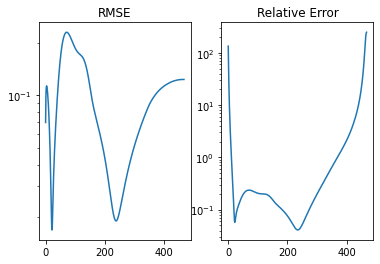

In [36]:
#compute error
with torch.no_grad():
    err_L2 = torch.sqrt(torch.sum((y_pred_auto - y_test_series)**2, axis=0) / y_test_series.shape[0])
    denominator = torch.sqrt(torch.sum(y_test_series**2, axis=0) / y_test_series.shape[0]) + 1e-4
    err_L2_rel = err_L2 / denominator
    mse = mean_squared_error(y_test_series.detach().numpy().reshape((-1,y_test_series.shape[1])), y_pred_auto.detach().numpy().reshape(-1,y_test_series.shape[1]))
    print('Mean squared error = ', mse)
    fig, ax = plt.subplot_mosaic([["abs", "rel"]])
    ax["abs"].semilogy(err_L2)
    ax['abs'].set_title('RMSE')
    ax['rel'].set_title('Relative Error')
    ax["rel"].semilogy(err_L2_rel)
    plt.show()

## Statistical Analysis of the residuals

To compare whether the model containing the simulation parameters x performs better than just the autoregressive model, we compare their sum of squared residuals using the F-test. For this we first have to check whether the resiuals are indeed normally distributed.


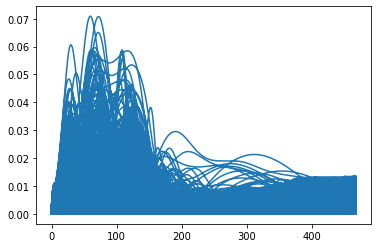

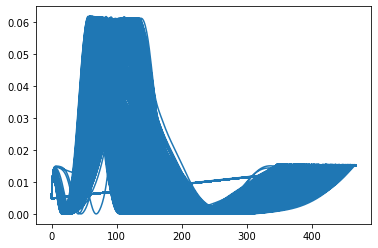

In [37]:
#plot the squared residuals of the test error of both sequence models
res = ((y_test_series-y_pred)**2).reshape(-1)
#plt.plot(res.T, linestyle = '--')
plt.plot(np.tile(np.arange(y_test_series.shape[1]), y_test_series.shape[0]),res)
plt.show()
res_auto = ((y_test_series-y_pred_auto)**2).reshape(-1)
plt.plot(np.tile(np.arange(y_test_series.shape[1]), y_test_series.shape[0]),res_auto)
plt.show()

/home/matthias/environments/master/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


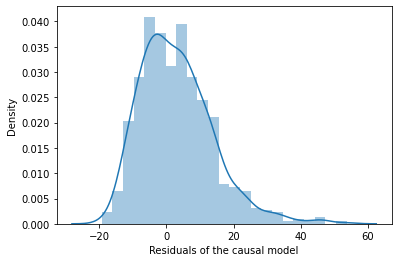

/home/matthias/environments/master/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


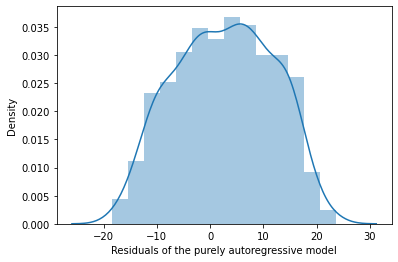

In [38]:
from scipy.stats import f_oneway, ttest_rel

#calculating the residuals
res = torch.sum((y_test_series-y_pred), axis = 1).reshape(-1)
res_auto = torch.sum((y_test_series-y_pred_auto), axis = 1).reshape(-1)

#we can see that the residuals are roughly normal
sns.distplot(res)
plt.xlabel('Residuals of the causal model')
plt.show()
sns.distplot(res_auto)
plt.xlabel('Residuals of the purely autoregressive model')
plt.show()

In [39]:
from scipy.stats import shapiro

print(shapiro(res))
print(shapiro(res_auto))

ShapiroResult(statistic=0.9506821036338806, pvalue=2.285440242545851e-14)
ShapiroResult(statistic=0.9823599457740784, pvalue=2.3580064123507327e-07)


The p-values are extremely small so we can be sure that the residuals are gaussian distributed. Thus, the sum of the squared residuals will be Chi-Squared distributed and using the F-statistic is justified.

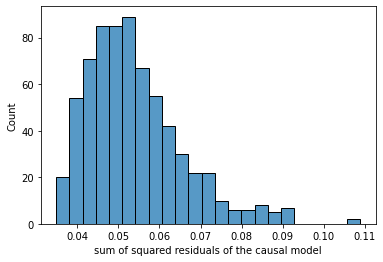

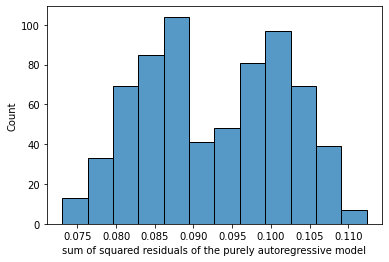

In [40]:
ssr = torch.sqrt(torch.sum((y_test_series-y_pred)**2, axis = 1)/y_pred.shape[0]).reshape(-1)
ssr_auto = torch.sqrt(torch.sum((y_test_series-y_pred_auto)**2, axis = 1)/y_pred_auto.shape[0]).reshape(-1)

#sum of squared residuals are chi-squared distributed
sns.histplot(ssr)
plt.xlabel('sum of squared residuals of the causal model')
plt.show()
sns.histplot(ssr_auto)
plt.xlabel('sum of squared residuals of the purely autoregressive model')
plt.show()

In [41]:
#ANOVA 
f_oneway(res,res_auto)

F_onewayResult(statistic=0.48727396621732927, pvalue=0.4852643108828133)

In [42]:
ttest_rel(ssr, ssr_auto, alternative = 'less')

Ttest_relResult(statistic=-74.10028648990607, pvalue=0.0)

We can see that the residuals of the purely autoregressive model are in fact smaller